In [2]:
import json
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os

In [44]:
smokescreen = True

In [45]:
# get directories for data loading

# TODO
# extend to combine data across experiment runs

# test_dirs contains subdirectories for each test experiment to be loaded
# test_dirs = ["results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA"]

# test_dirs = ["debug_results/test_CBayes-func_schwefel-dim_1-kern_Matern32-runs_5-iters_150-init_samp_50-noise_0.100000-exp_bias_0.250000_03-18-22_12:12:41",
#              "debug_results/test_PyRef-impl_skopt-func_schwefel-dim_1-kern_Matern32-runs_5-iters_150-init_samp_50-noise_0.1-exp_bias_0.25_03-18-22_12:25:06"]
test_dirs = None

if test_dirs is None:
    # cluster_run_dirs populates test_dirs with all subdirectories of each directory in cluster_run_dirs
    # useful when a single conceptual experiment involved several parameter combinations
    cluster_run_dirs = ["results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA"]
#     cluster_run_dirs = ["results/debug/CBay2_CBay",
#                         "results/debug/skopt0_skopt"]
#     cluster_run_dirs = ["results/BoundFix_3_13_22_CBay",
#                         "results/init_runs_skopt"]
    test_dirs = []
    for d in cluster_run_dirs:
#         print(d)
        i = 0
        for r in os.listdir(d):
            if smokescreen and i > 3:
                continue
            if not os.path.isdir(os.path.join(d, r)): continue
#             print(os.path.join(d, r))
            test_dirs.append(os.path.join(d, r))
            i += 1

print(f"Number of experiments loaded: {len(test_dirs)}")

for d in test_dirs[:3]:
    print(d)


Number of experiments loaded: 4
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_25-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.100000_03-17-22_20:20:26
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_25-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.500000_03-17-22_20:20:41
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_100-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.500000_03-17-22_20:20:41


In [46]:
# load data

# TODO
# extend to search samples

exp = "CSearchComparison"  # CSearchComparison tests (testCSearchComparison_full.cpp)
# exp = "CBayesianSearch"  # BayesianSearch tests (testBayesianSearch.cpp)

# tips = sns.load_dataset("tips")
# ax = sns.boxplot(x=tips["total_bill"])
# ax = sns.boxplot(x="day", y="total_bill", hue="smoker",
#                  data=tips, palette="Set3")
# import pdb; pdb.set_trace()
# plt.show()
# exit()

configs = []
config_keys = ["exp_bias", "n_iters", "n_init_samp", "n_init_samples", "noise_level", "kern", "kernel", "n_runs"]
if exp == "CSearchComparison":
    config_keys.extend(["mean_diff", "n_way", "n_grid"])

results = []
run_results = []
run_df = pd.DataFrame()

for i, d in enumerate(test_dirs):
    print(d)
    try:
        with open(os.path.join(d, "log.json")) as f:
            results.append(json.load(f))
        with open(os.path.join(d, "config.json")) as f:
            configs.append(json.load(f))
    except:
        if len(results) > len(configs): results.pop(-1)
        continue
    
    n_runs = configs[-1]["n_runs"]
    model = configs[-1]["impl"]  #configs[-1]["tag"]
    excluded_func = []
    res = results[-1]
    
    # iterate over test functions
    for f, fv in res.items():
        if f in excluded_func: continue
        temp = dict()
        
        if exp == "CBayesianSearch":
            exp_len = n_runs
            temp["Function"] = [f] * exp_len
            temp["Model"] = [model] * exp_len
            temp["Relative Error"] = np.array(fv["relative errors"])[:, -1]
            temp["Max Sample Run Times"] = np.array(fv["sample times"])[:, -5:].mean(axis=1)
            temp["run"] = np.arange(n_runs)
        elif exp == "CSearchComparison":
            n_way = configs[-1]["n_way"]
            exp_len = n_runs * n_way
            temp["Function"] = [f] * exp_len
            temp["Model"] = [model] * exp_len
            # load experiment-level results
            for k in ["power", "Proportion_correct", "correct_model"]:
                temp[k] = np.array([fv[k]] * exp_len)
                
            # load run-level results
            # results stored run-by-way (or number of discrete treatments being compared)
            for k in ["pvals"]:
                temp[k] = list()
                for r in range(n_runs):
                    temp[k].extend([fv[k][r]] * n_way)

            temp["way"] = list()
            temp["run"] = list()
            for r in range(n_runs):
                temp["way"].extend([i for i in range(n_way)])
                temp["run"].extend([r] * n_way)

            # load way-level results
            temp["Relative Error"] = list()
            for r in range(n_runs):
                for w in range(n_way):
                    temp["Relative Error"].append(fv["run"][0][0]["relative errors"][0])
            
            # get comparison_struct results
            for k in ["mus", "ns", "sems", "xs"]:
                temp[k] = list()
                for r in range(n_runs):
                    for w in range(n_way):
                        temp[k].append(fv["run"][r][0]["comparison_struct"][k][w])
            
            k = "idx_best"
            temp[k] = list()
            for r in range(n_runs):
                temp[k].extend([fv["run"][r][0]["comparison_struct"][k]] * n_way)

        # other config parameters for comparison
        for k in config_keys:
            if k not in configs[-1].keys():
                continue
            if k == "n_init_samples":  # handle special case in naming differences
                temp["n_init_samp"] = [configs[-1][k]] * exp_len
            elif k == "kernel":  # handle special case in naming differences
                temp["kern"] = [configs[-1][k]] * exp_len
            else:
                temp[k] = [configs[-1][k]] * exp_len
            
        run_df = run_df.append(pd.DataFrame(temp))
    
# for i, r in enumerate(results):
#     print(configs[i]["system"])

if exp == "CSearchComparison":
    run_df["correct"] = np.array(run_df["correct_model"] == run_df["idx_best"]).astype(int)
    
#     run_df["max_mu_idx"] = run_df.groupby([k for k in run_df.columns if k != "n_way"]).reset_index()["max_mu_idx"]

def reduce2one(df, cols):
    df = df.iloc[[0]].drop([col for col in df.columns if col not in cols], axis="columns")
    return df

outcome_keys = ["mus", "ns", "sems", "xs", "idx_best", "power", "pvals", "correct"]
keys2exclude = outcome_keys + ["run"]
# run_df.groupby([k for k in run_df.columns if k not in keys2exclude]).mean().reset_index().head(10)
# run_df.groupby([k for k in run_df.columns if k not in keys2exclude]).apply(reduce2one, cols=keys2exclude).reset_index().head(10)

print(run_df.columns)


results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_25-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.100000_03-17-22_20:20:26
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_25-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.500000_03-17-22_20:20:41
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_100-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.500000_03-17-22_20:20:41
results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_100-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.100

In [48]:
# np.array(fv['run'][0][0]["x_samples"][0][0])
fv['run'][0][0]["y_samples"][0][0][0]

-170.1759291866708

In [54]:
run_df.loc[:, ["idx_best", "correct_model", "correct", "power"]].head(10)

,idx_best,correct_model,correct,power
0,1,0,0,0.35
1,1,0,0,0.35
2,0,0,1,0.35
3,0,0,1,0.35
4,0,0,1,0.35
5,0,0,1,0.35
6,0,0,1,0.35
7,0,0,1,0.35
8,1,0,0,0.35
9,1,0,0,0.35


In [197]:
list(run_df.columns)
# [k for k in run_df.columns if k != "run"]

['Function',
 'Model',
 'power',
 'Proportion_correct',
 'correct_model',
 'pvals',
 'way',
 'run',
 'mus',
 'ns',
 'sems',
 'xs',
 'idx_best',
 'exp_bias',
 'n_iters',
 'n_init_samp',
 'noise_level',
 'kern',
 'n_runs',
 'mean_diff',
 'n_way',
 'correct']

In [32]:
len(run_df)

5600

In [49]:
run_df.head()

,Function,Model,power,Proportion_correct,correct_model,pvals,way,run,mus,ns,sems,idx_best,exp_bias,n_iters,n_init_samp,noise_level,kern,mean_diff,n_way
0,quadratic:d1,CSearchComparison,0.35,0.63,0,0.268963,0,0,1.033518,47.502841,0.014440,1,0.1,150,25,0.1,Matern32,0.3,2
1,quadratic:d1,CSearchComparison,0.35,0.63,0,0.268963,1,0,1.010944,50.748813,0.014271,1,0.1,150,25,0.1,Matern32,0.3,2
2,quadratic:d1,CSearchComparison,0.35,0.63,0,0.022243,0,1,1.038769,52.847094,0.013944,0,0.1,150,25,0.1,Matern32,0.3,2
3,quadratic:d1,CSearchComparison,0.35,0.63,0,0.022243,1,1,0.990190,43.628856,0.015547,0,0.1,150,25,0.1,Matern32,0.3,2
4,quadratic:d1,CSearchComparison,0.35,0.63,0,0.023146,0,2,1.047471,49.301046,0.014123,0,0.1,150,25,0.1,Matern32,0.3,2


In [45]:
configs[0]

{'GIT_BRANCH': 'refs/heads/bayes',
 'GIT_COMMIT': 'a75df64',
 'GIT_URL': 'git@github.com:Riley16/BayesGPc.git',
 'datetime': '03-17-22_20:20:26',
 'dim': 1,
 'exp_bias': 0.1,
 'func': 'all',
 'impl': 'CSearchComparison',
 'kern': 'Matern32',
 'logdir': '/home1/rdehaan/projects/BayesGPc/results/CSearchComparison_after_sample_error_catch_3_17_22_ANOVA/CSearchComparison_after_sample_error_catch_3_17_22-func_all-dim_1-kern_Matern32-runs_100-iters_150-init_samp_25-n_way_2-mean_diff_0.300000-noise_0.100000-exp_bias_0.100000_03-17-22_20:20:26',
 'mean_diff': 0.3,
 'n_init_samp': 25,
 'n_iters': 150,
 'n_runs': 100,
 'n_way': 2,
 'noise_level': 0.1,
 'plot': False,
 'seed': 1234,
 'tag': 'CSearchComparison_after_sample_error_catch_3_17_22',
 'verbosity': 1}

In [44]:
for k, v in temp.items():
    print(k, len(v))

Function 200
Model 200
power 200
Proportion_correct 200
pvals 200
mus 200
ns 200
sems 200
xs 200
idx_best 200
exp_bias 200
n_iters 200
n_init_samp 200
noise_level 200
kern 200
mean_diff 200
n_way 200


In [28]:
results[0]["quadratic:d1"].keys()

dict_keys(['Proportion_correct', 'correct_model', 'exception runs', 'kernel_structure', 'power', 'pvals', 'run'])

In [33]:
results[0]["quadratic:d1"]["run"][0][0]["comparison_struct"]# .keys()

{'idx_best': 1,
 'mus': [1.0335175857543173, 1.0109440945692563],
 'ns': [47.50284093591967, 50.748812754491226],
 'pval': 0.2689626914759693,
 'sems': [0.014440061004288301, 0.014270796576250723],
 'xs': [[0.9999999999999929], [0.999999999999992]]}

In [18]:
run_df["Model"].unique()

array(['CBay', 'skopt'], dtype=object)

In [212]:
# comparison of optimization algos across runs and parameters
for iters in run_df["n_iters"].unique():
    for nl in run_df["noise_level"].unique():
        for eb in run_df["exp_bias"].unique():
            for init in run_df["n_init_samp"].unique():
                for k in run_df["kern"].unique():
                    df = run_df.loc[(run_df["exp_bias"] == eb) &
                                    (run_df["noise_level"] == nl) & 
                                    (run_df["kern"] == k) &
                                    (run_df["n_iters"] == iters) &
                                    (run_df["n_init_samp"] == init)
                                    ]
#                     print("eb", eb, "nl", nl, "k", k, "iters", iters, "init", init)
                    if len(df) == 0: continue
#                     if len(df["Model"].unique()) < 2: continue
#                     print(df.head())
                    plt.figure()
                    sns.boxplot(y="Function",
                                x="Relative Error",
                                hue="Model",
                                data=df,
                                # notch=True,
                                # bootstrap=2000
                                orient="h"
                                )
                    title = f"Relative Errors for exp_bias: {eb}, noise: {nl},\nkern: {k}, samples: {iters}, init_samples: {init}"
#                     print(title)
                    plt.title(title)
plt.show()

ValueError: Could not interpret input 'Relative Error'

<Figure size 432x288 with 0 Axes>

In [213]:
# GLM modeling

import statsmodels.api as sm
from scipy import stats

# statsmodels example
# data = sm.datasets.star98.load()
# data.exog = sm.add_constant(data.exog, prepend=False)

# data.exog = pd.DataFrame(data.exog, columns=["covar" + str(i) for i in range(data.exog.shape[1])])
# data.endog = pd.DataFrame(data.endog, columns=["NABOVE", "NBELOW"])

# glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
# res = glm_binom.fit()
# print(res.summary())

run_params = ["exp_bias", "n_iters", "n_init_samp", "noise_level", "n_way", "mean_diff"] # "kern"
outcome_keys = ["mus", "ns", "sems", "idx_best", "power", "pvals", "correct"]
keys2exclude = outcome_keys + ["run", "way", "xs"]

# reduce dataframe to single row per experiment
glm_df = run_df.groupby([k for k in run_df.columns if k not in keys2exclude]).apply(reduce2one, cols=keys2exclude).reset_index()
glm_df["N_correct"] = glm_df["Proportion_correct"] * glm_df["n_runs"]
glm_df["N_incorrect"] = glm_df["n_runs"] - glm_df["N_correct"]

glm_df["N_sig"] = glm_df["power"] * glm_df["n_runs"]
glm_df["N_insig"] = glm_df["n_runs"] - glm_df["N_sig"]

# print(glm_df.head(10))

func = "quadratic:d1"
glm_df = glm_df.query("Function==@func")

glm_df["constant"] = 1

print(glm_df.columns)

outcomes = ["N_sig", "N_insig"]

endog = glm_df.loc[:, outcomes]
exog = glm_df.loc[:, run_params + ["constant"]]

glm_binom = sm.GLM(endog, exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())


Index(['Function', 'Model', 'Proportion_correct', 'correct_model', 'exp_bias',
       'n_iters', 'n_init_samp', 'noise_level', 'kern', 'n_runs', 'mean_diff',
       'n_way', 'level_12', 'power', 'pvals', 'way', 'run', 'mus', 'ns',
       'sems', 'xs', 'idx_best', 'correct', 'N_correct', 'N_incorrect',
       'N_sig', 'N_insig', 'constant'],
      dtype='object')
                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['N_sig', 'N_insig']   No. Observations:                    4
Model:                              GLM   Df Residuals:                        1
Model Family:                  Binomial   Df Model:                            2
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -9.1745
Date:                  Mon, 06 Jun 2022   Deviance:                      0.65397
Time:                          17:19:35   Pearson chi2:             

In [202]:
glm_df.__len__()
# np.unique(run_df.Function)

3

/home1/rdehaan/.conda/envs/eeg3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


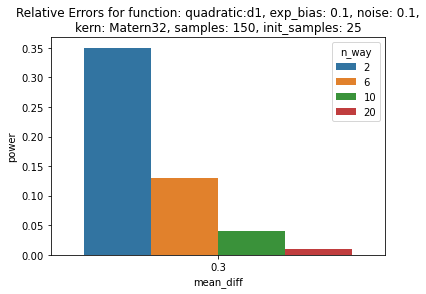

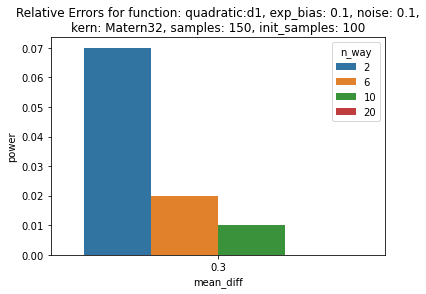

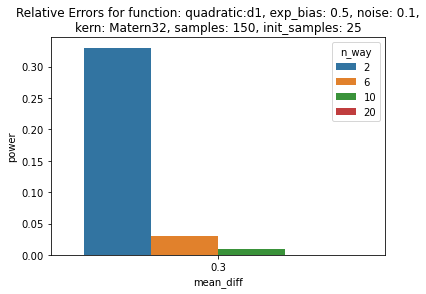

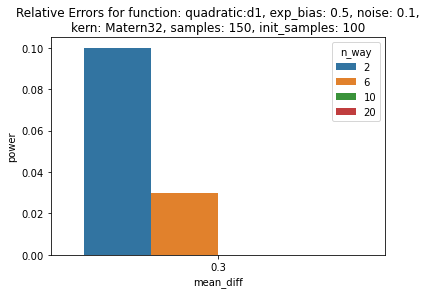

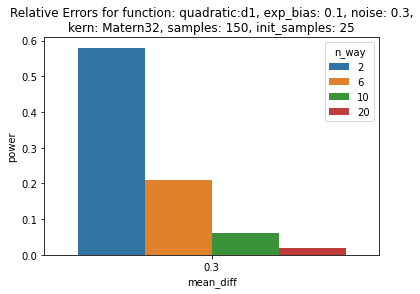

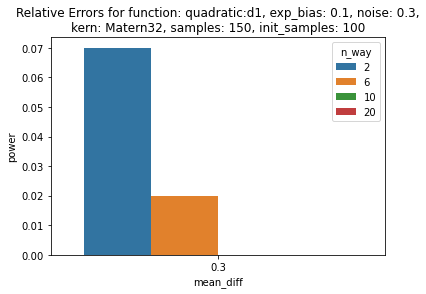

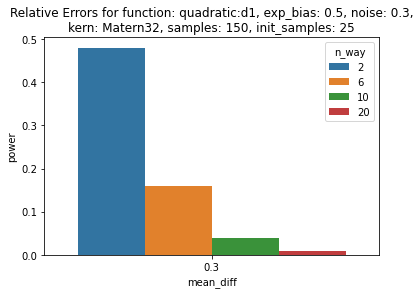

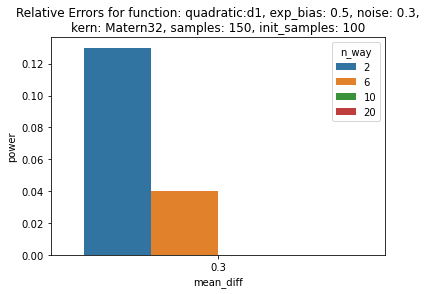

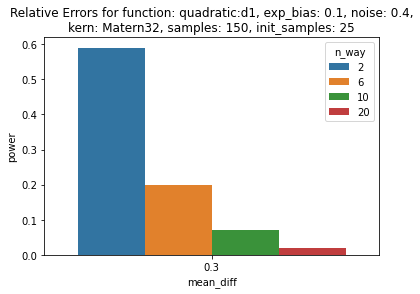

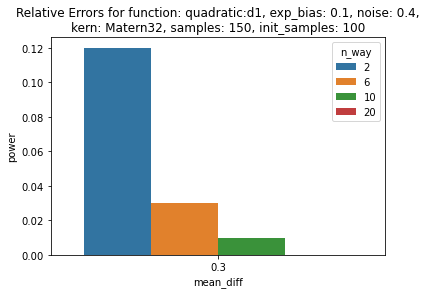

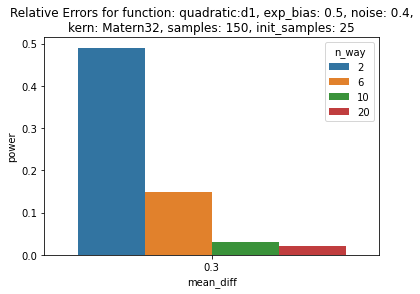

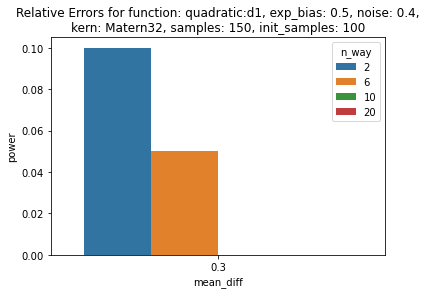

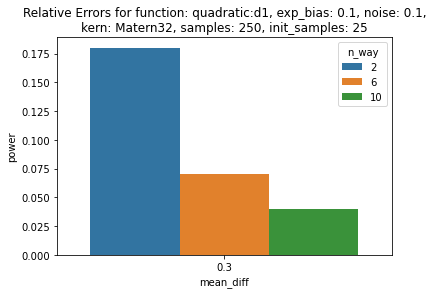

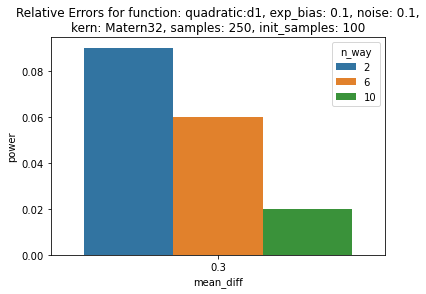

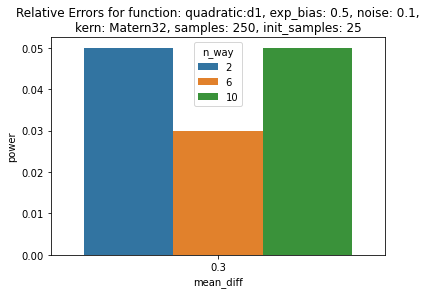

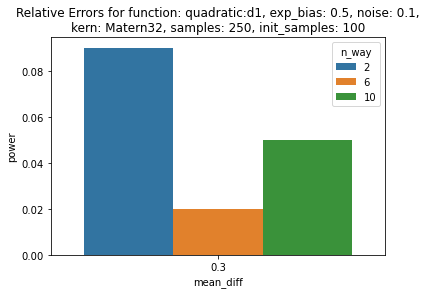

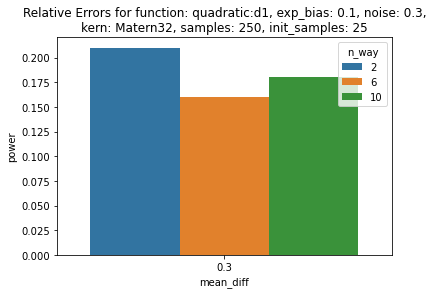

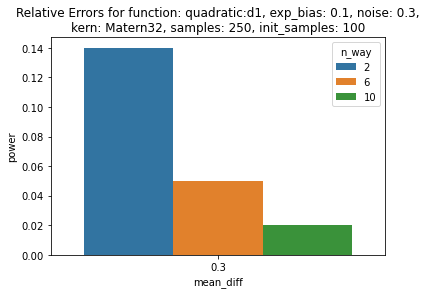

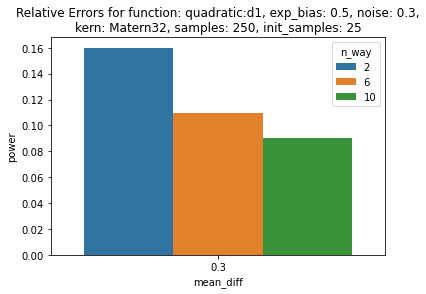

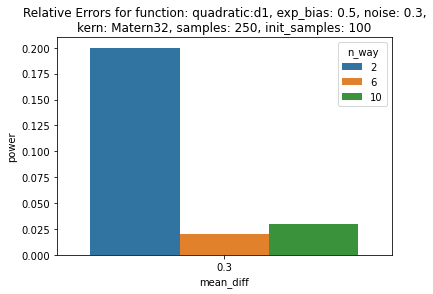

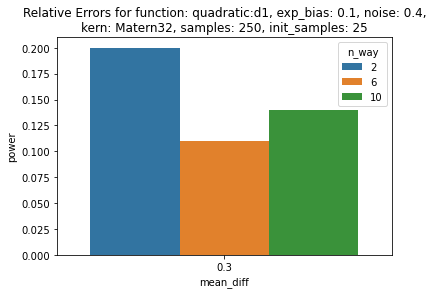

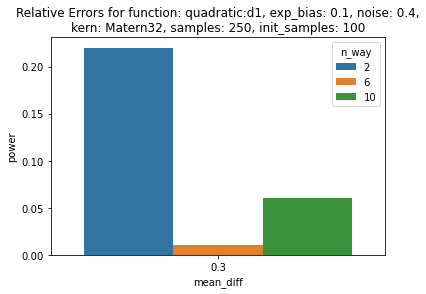

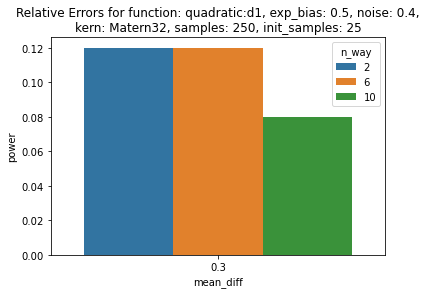

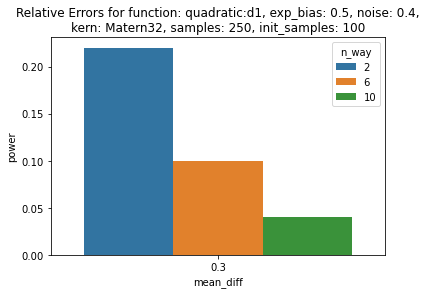

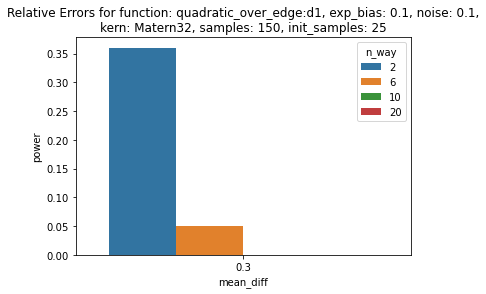

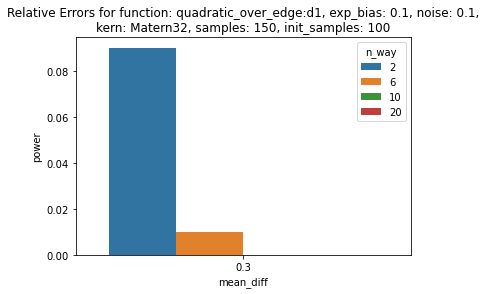

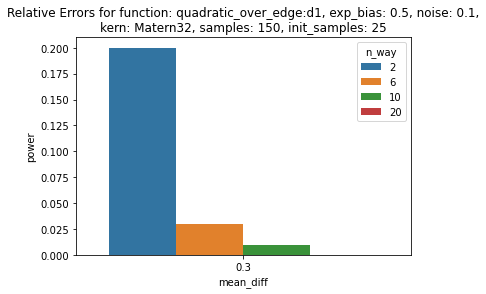

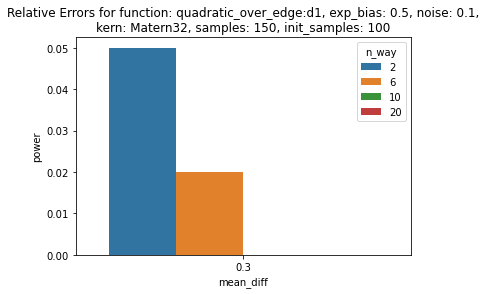

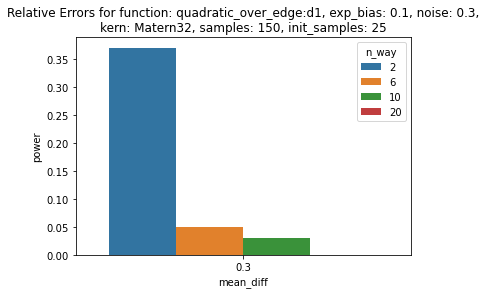

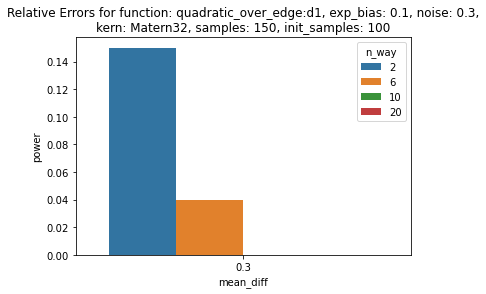

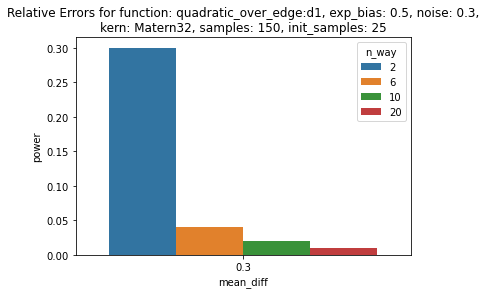

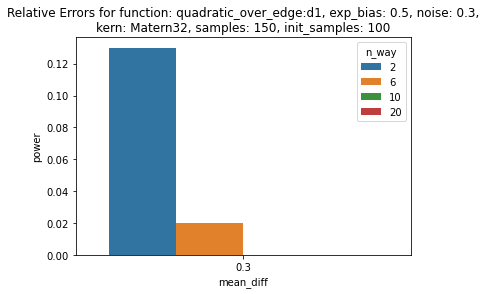

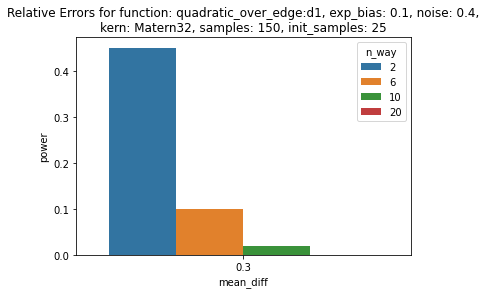

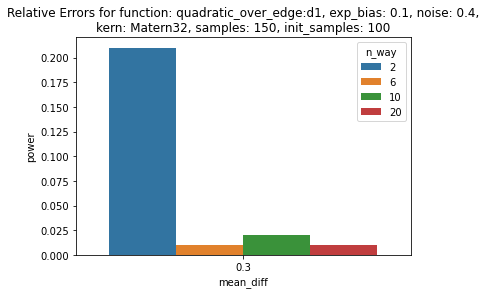

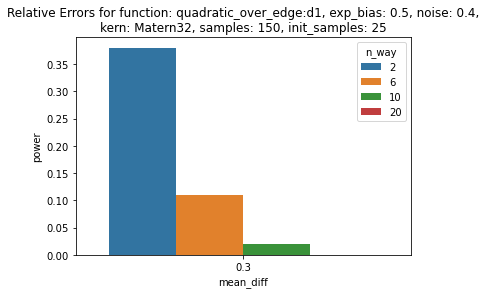

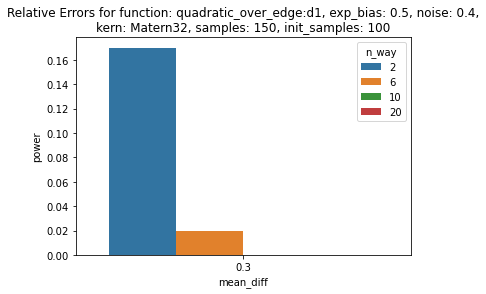

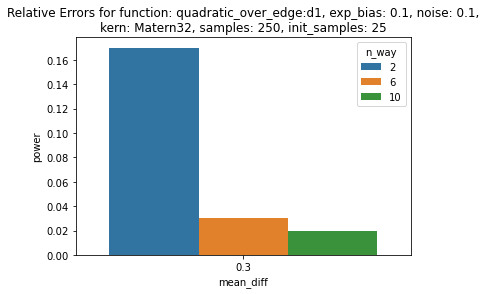

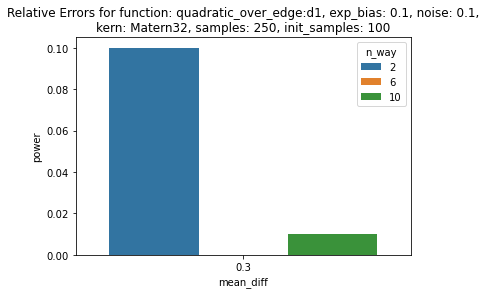

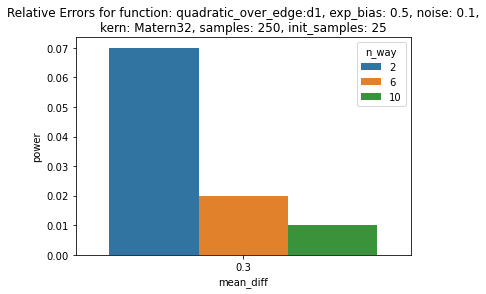

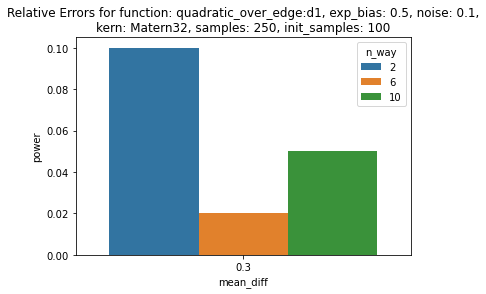

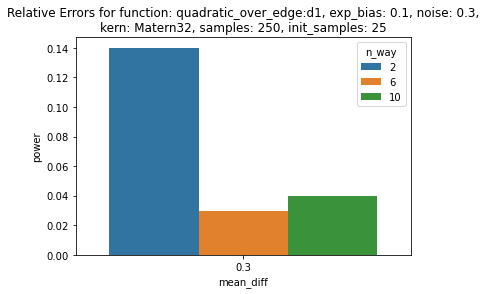

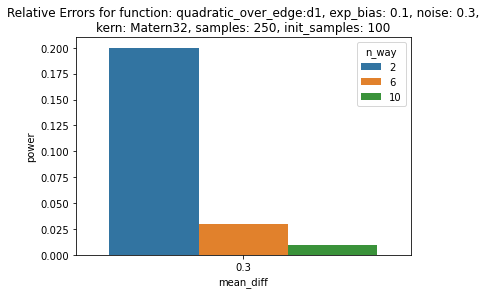

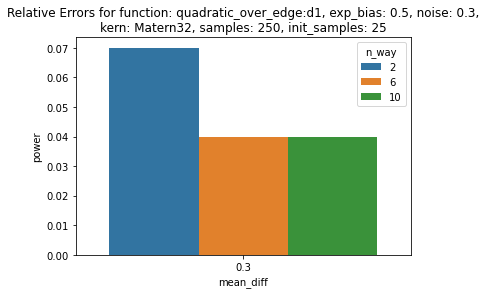

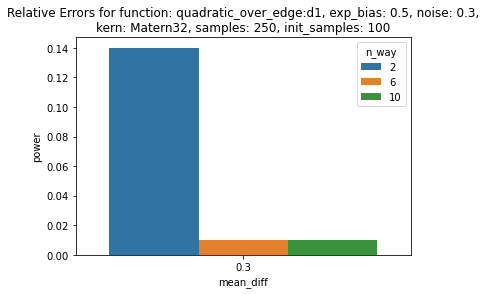

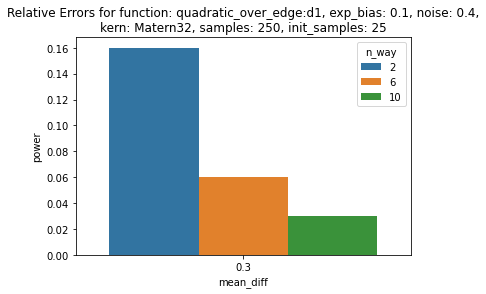

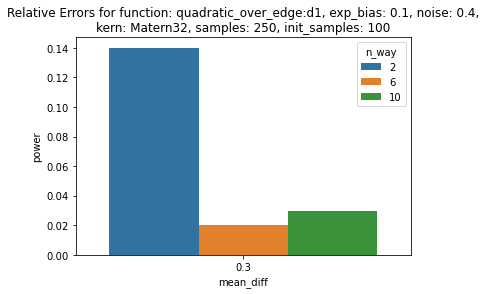

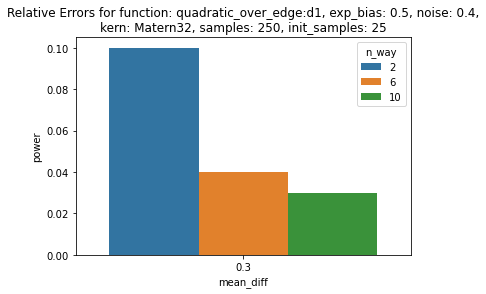

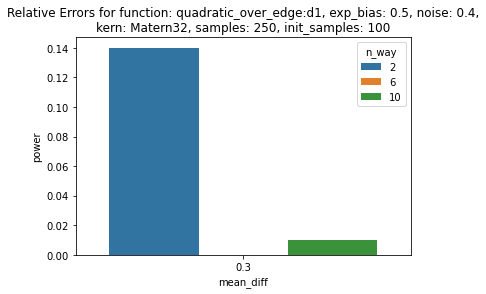

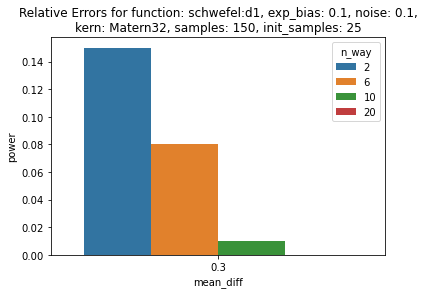

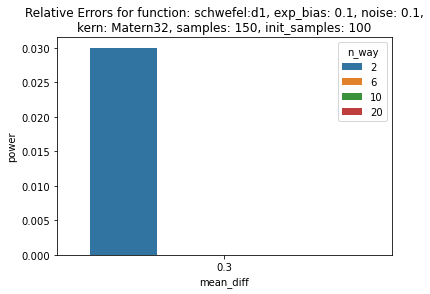

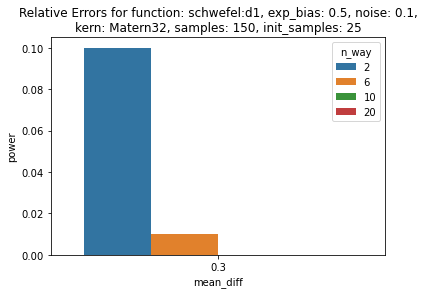

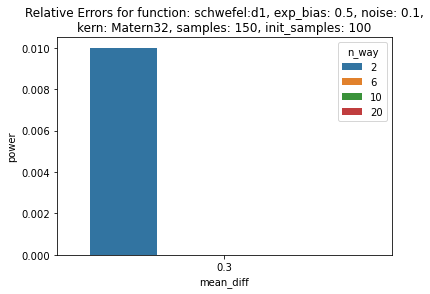

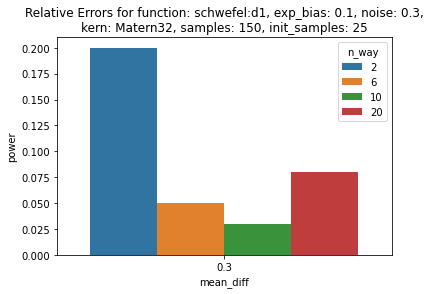

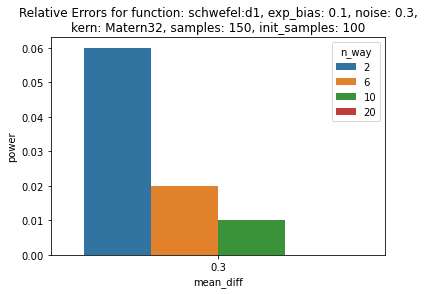

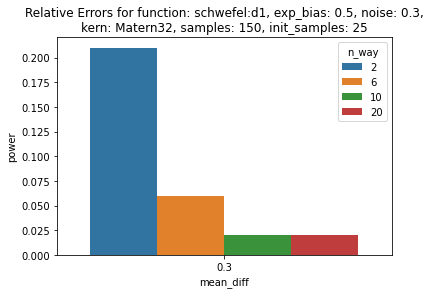

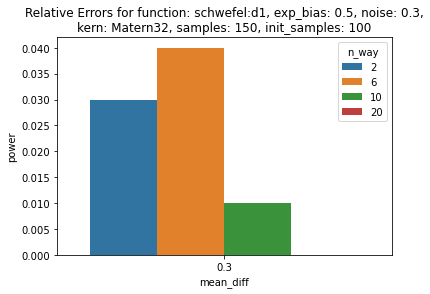

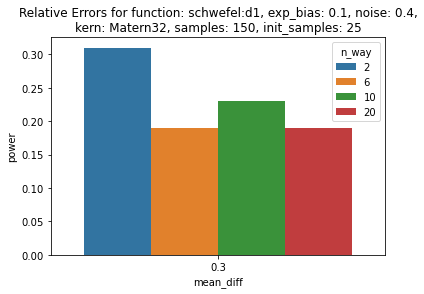

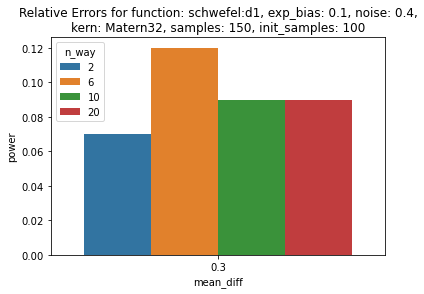

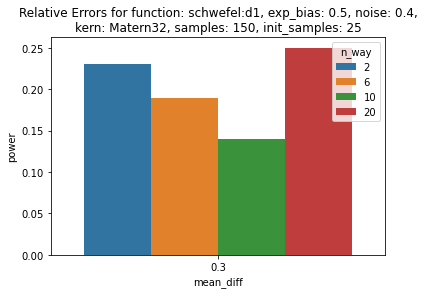

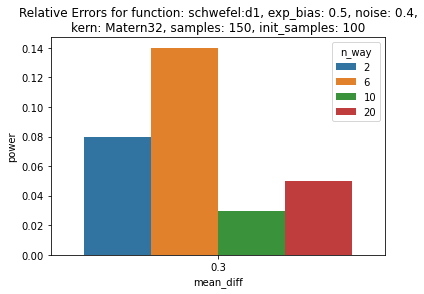

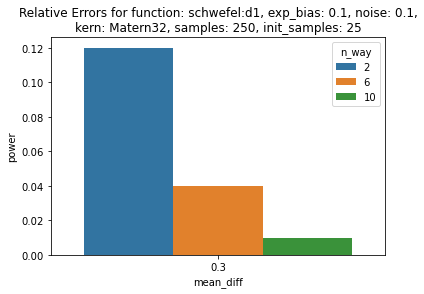

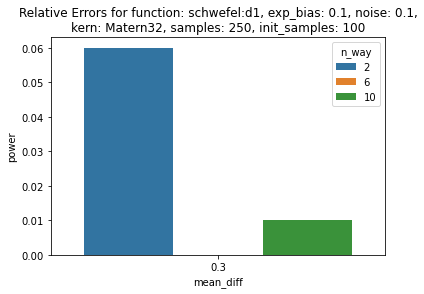

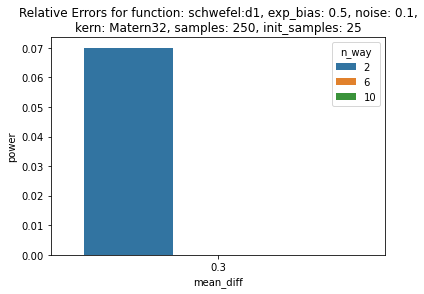

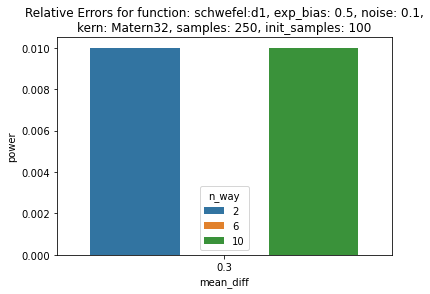

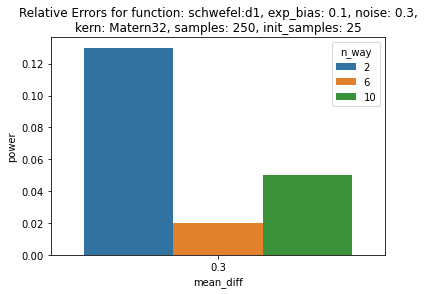

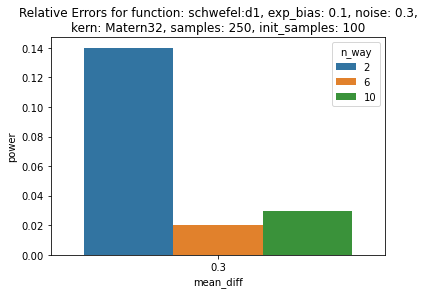

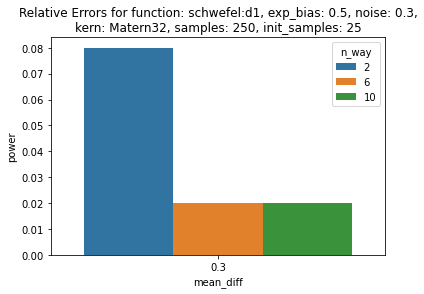

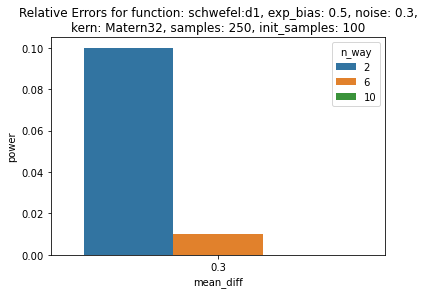

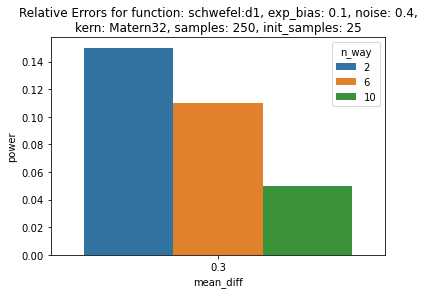

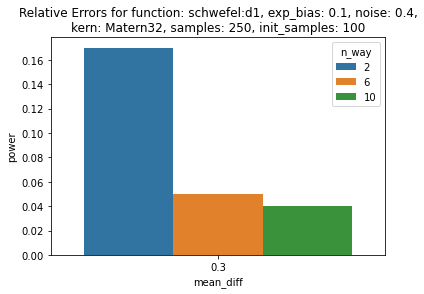

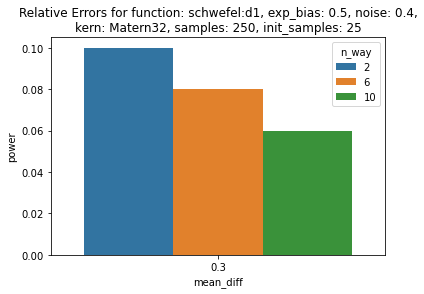

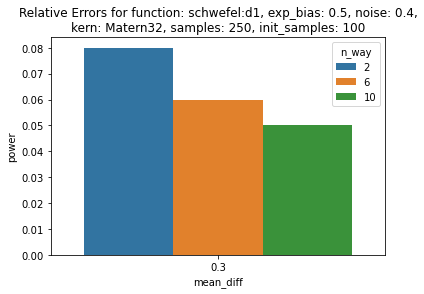

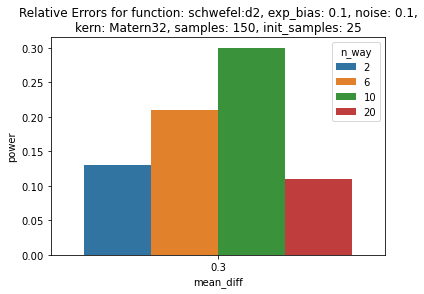

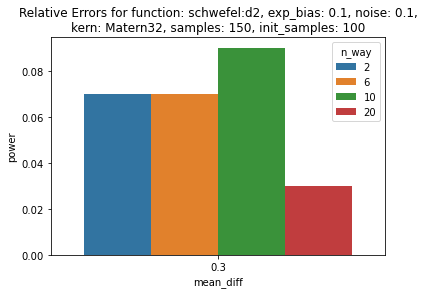

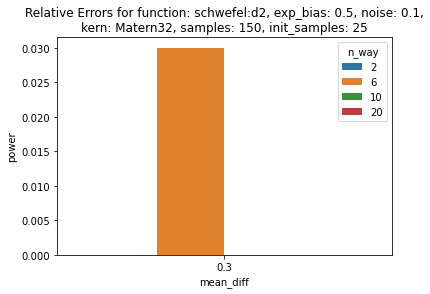

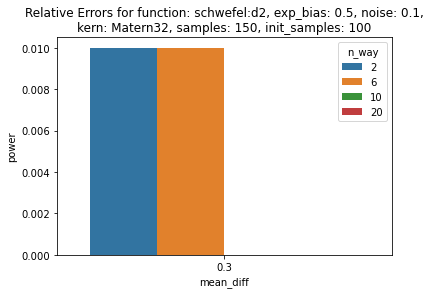

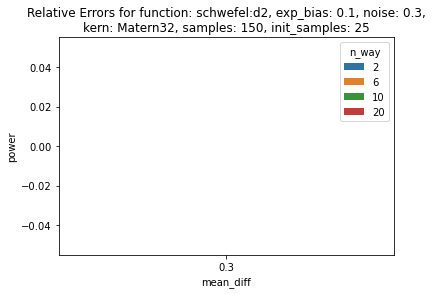

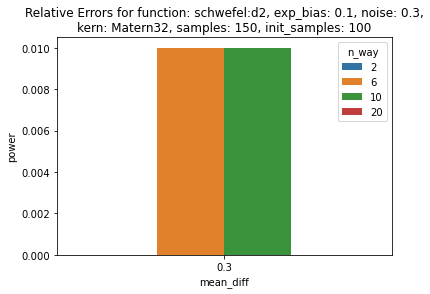

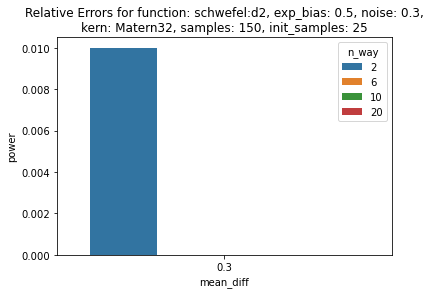

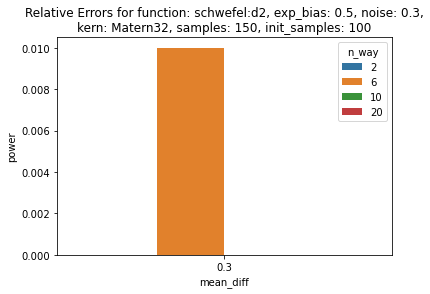

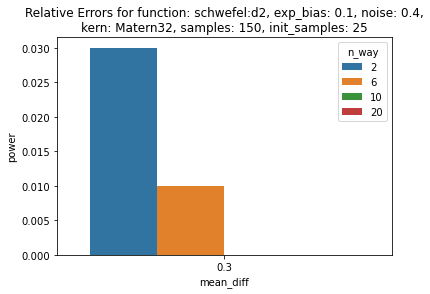

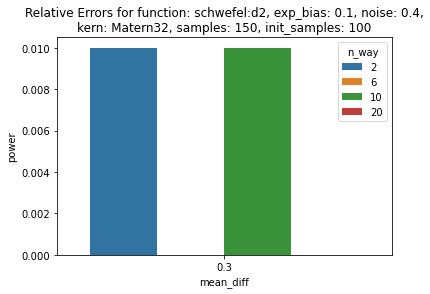

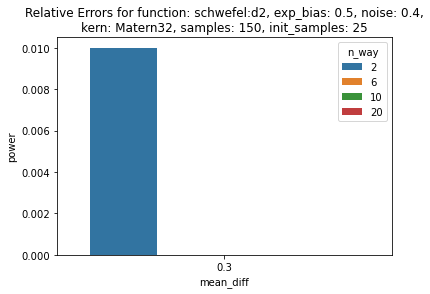

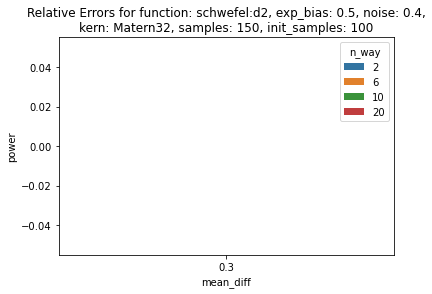

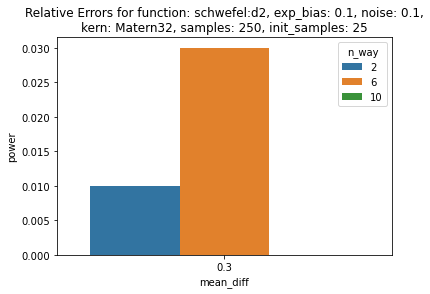

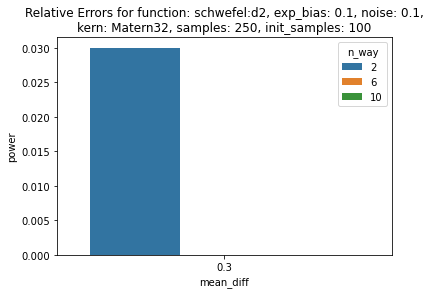

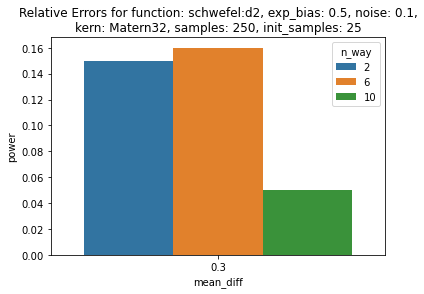

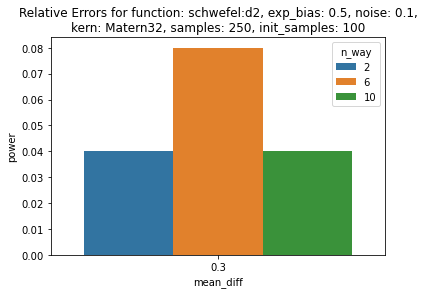

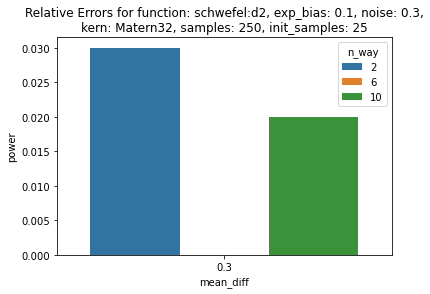

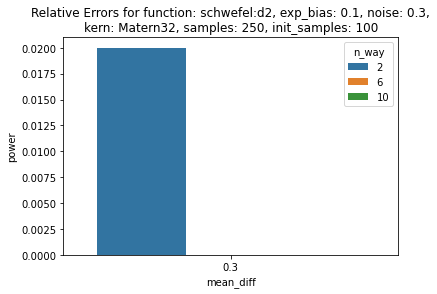

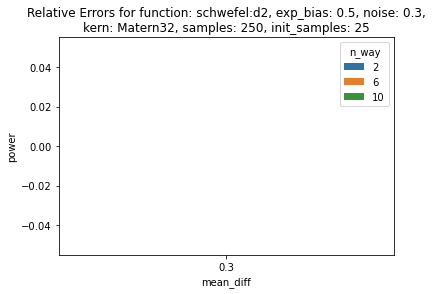

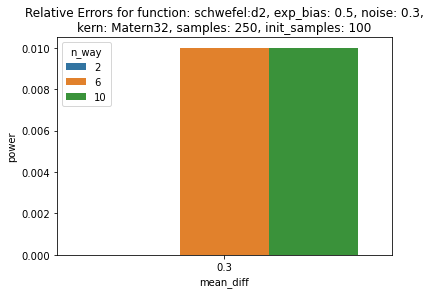

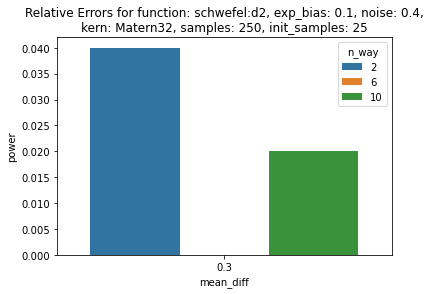

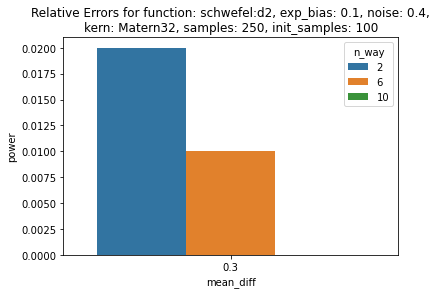

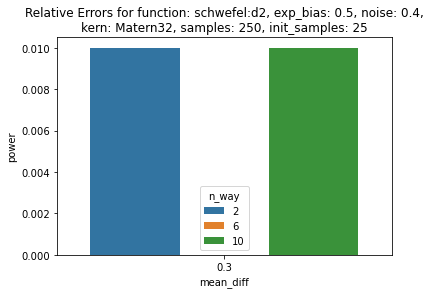

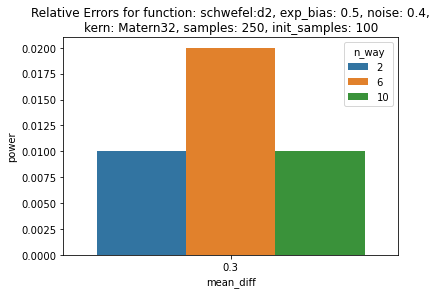

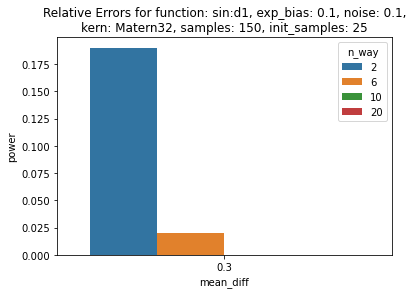

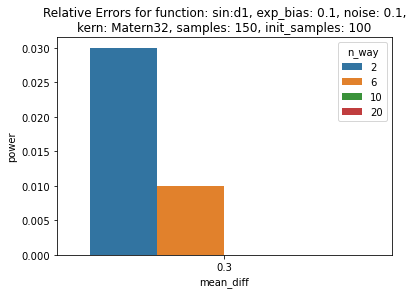

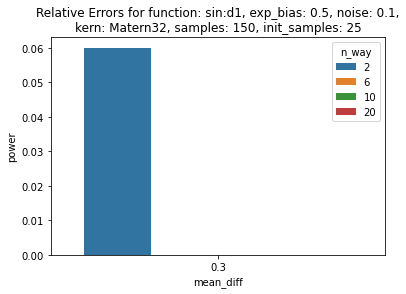

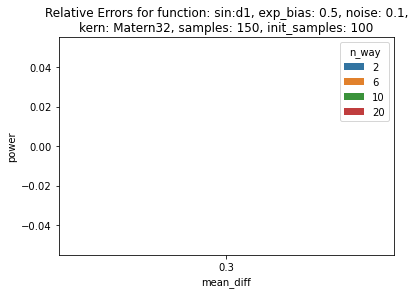

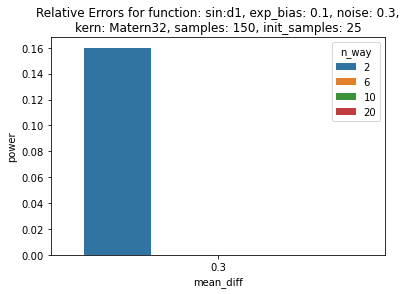

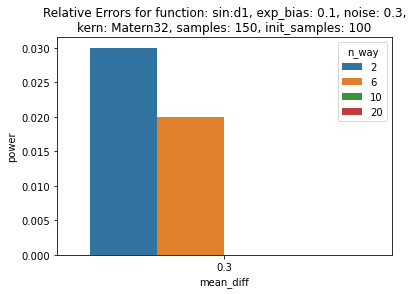

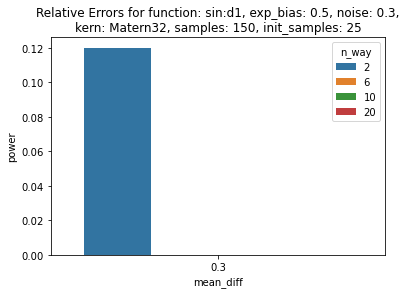

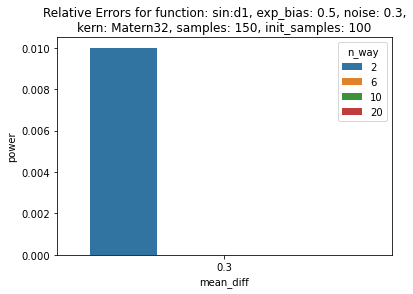

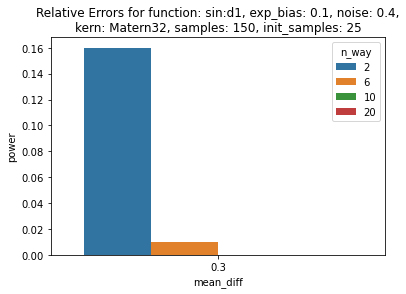

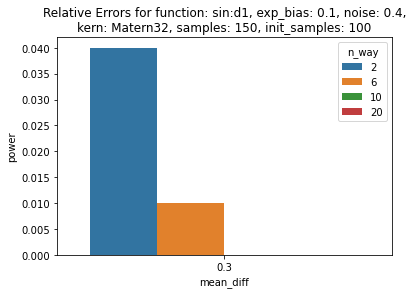

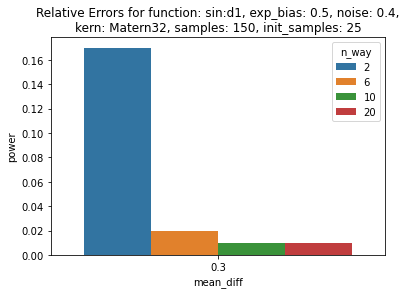

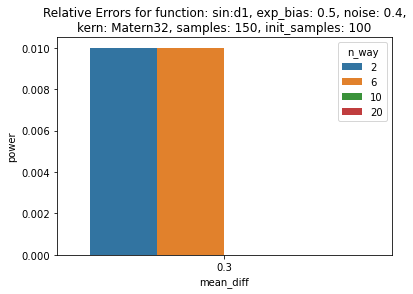

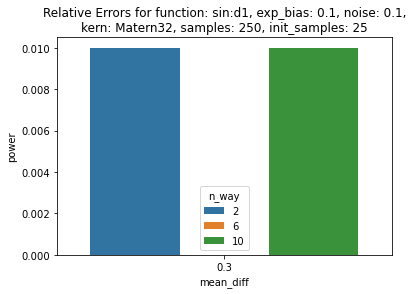

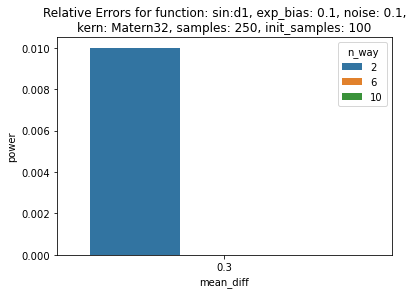

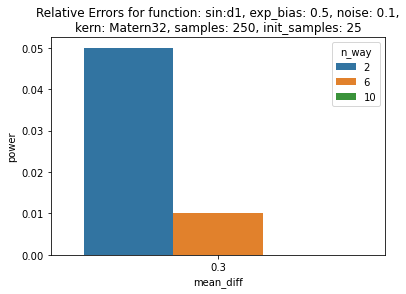

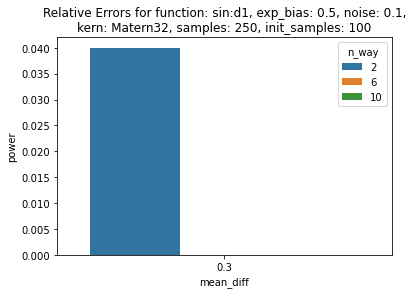

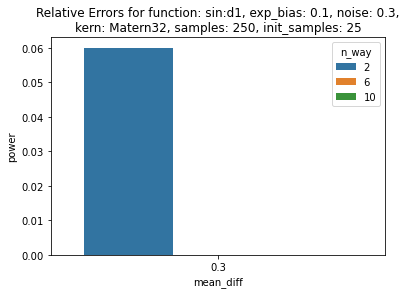

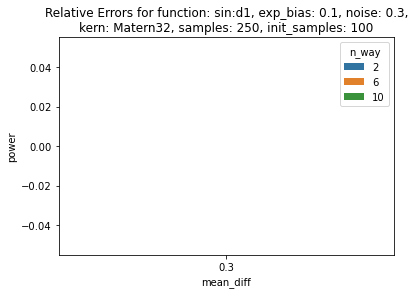

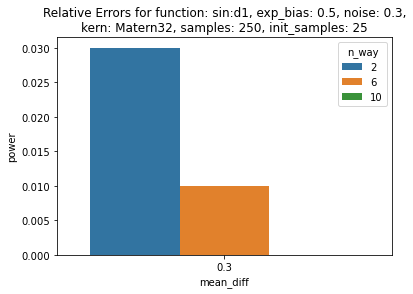

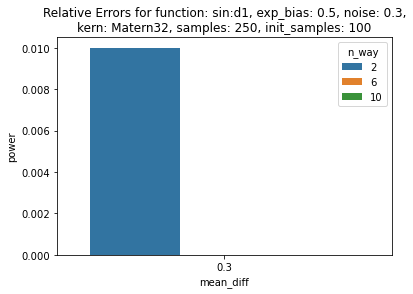

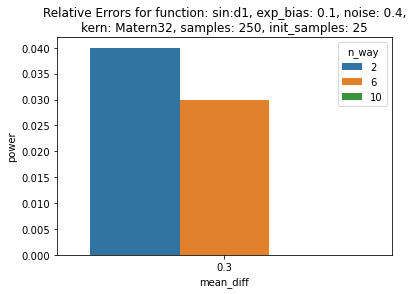

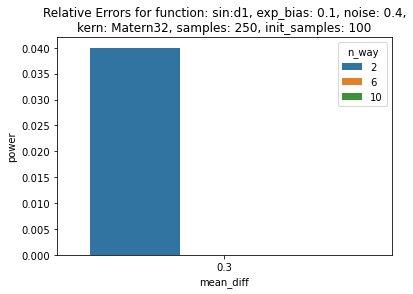

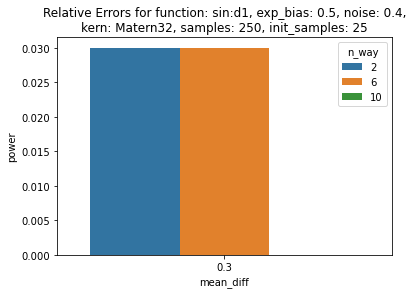

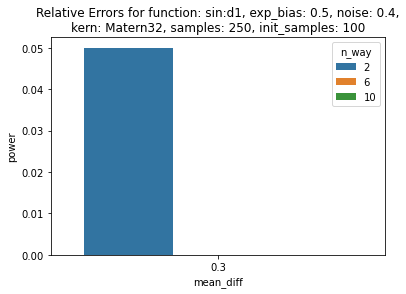

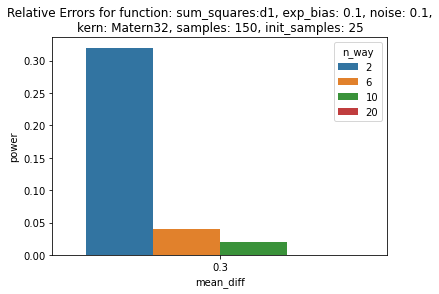

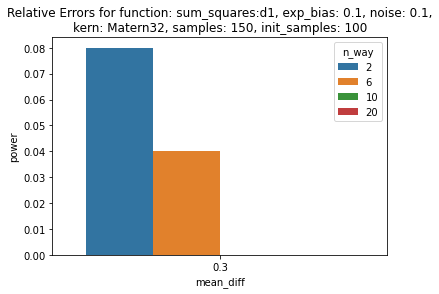

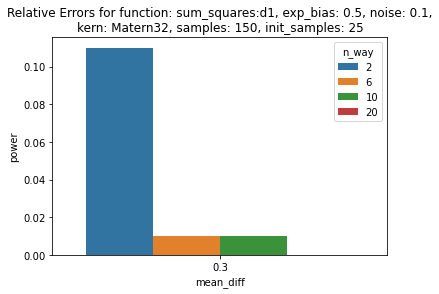

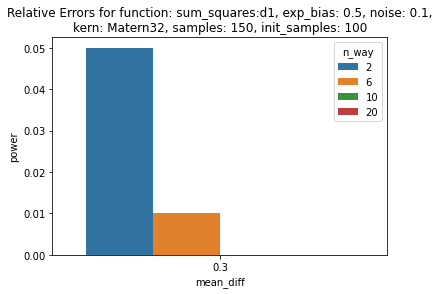

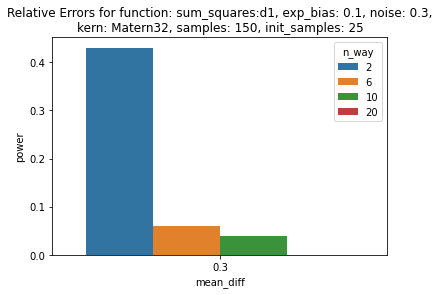

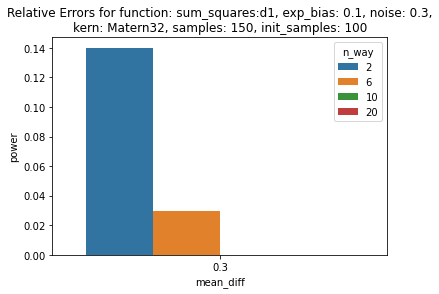

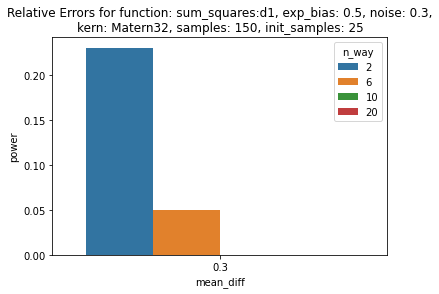

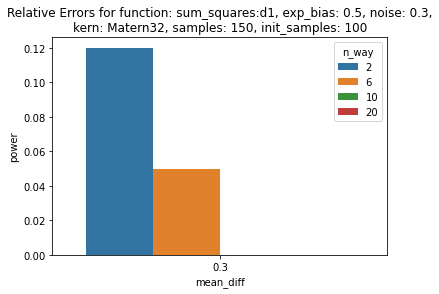

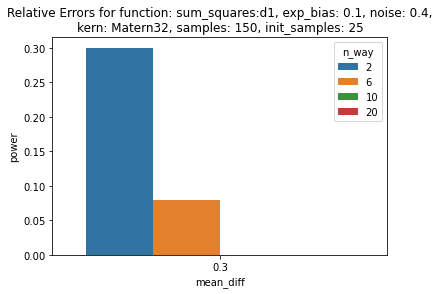

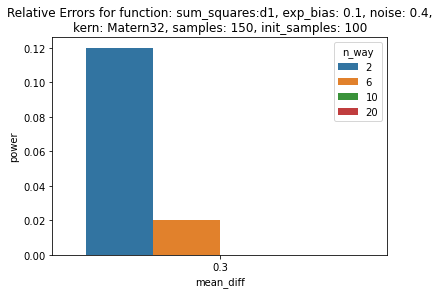

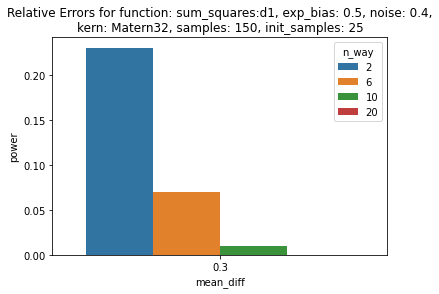

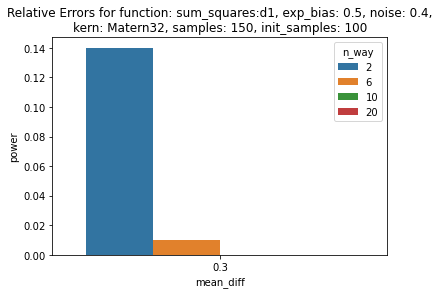

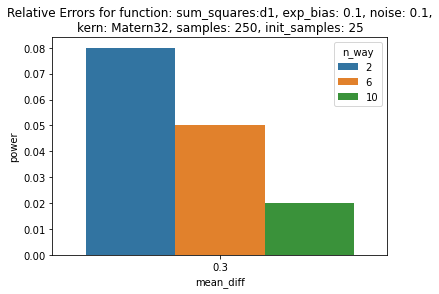

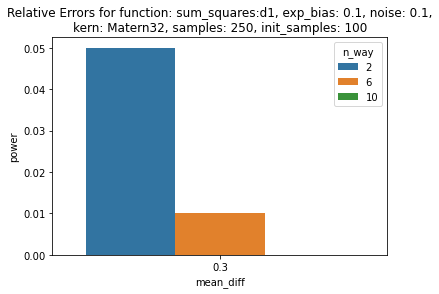

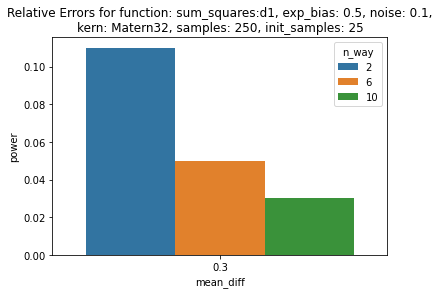

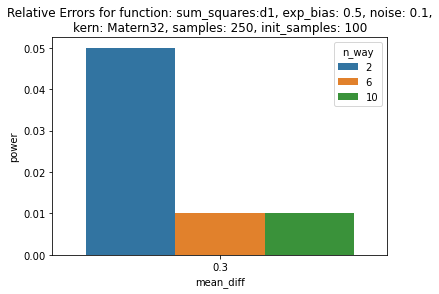

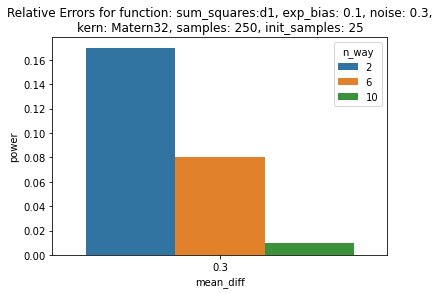

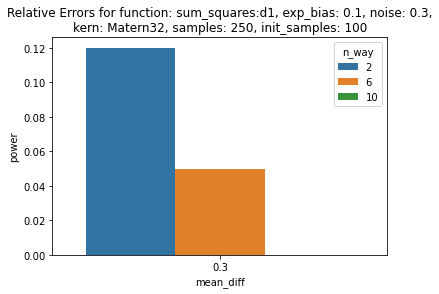

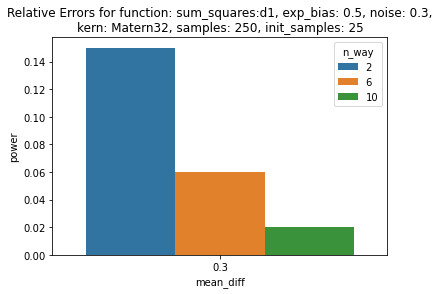

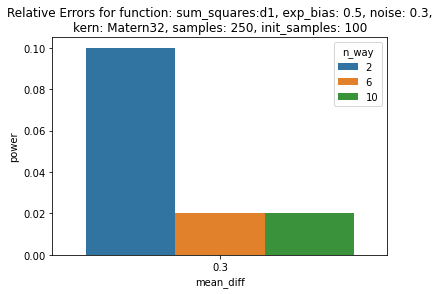

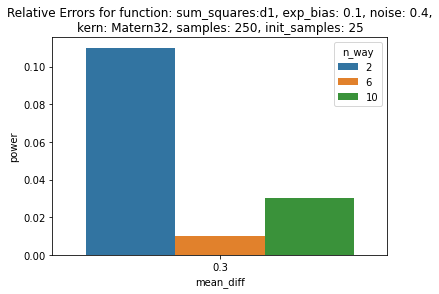

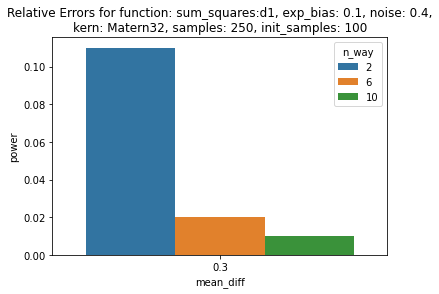

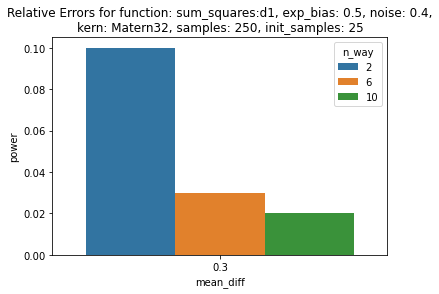

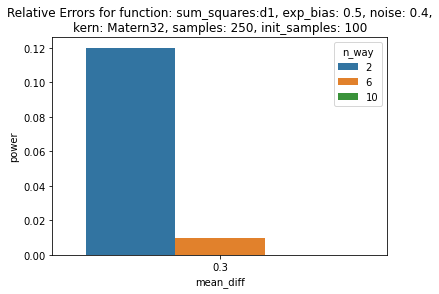

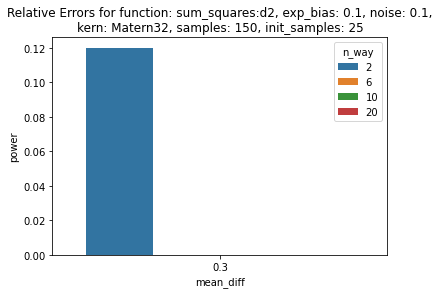

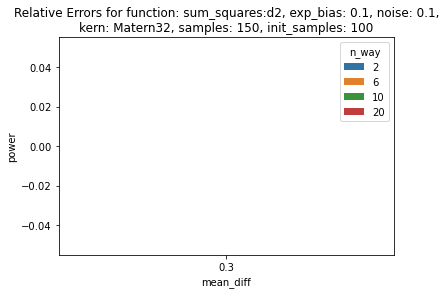

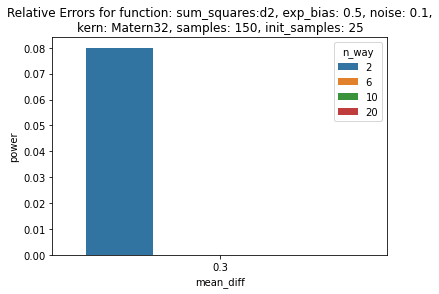

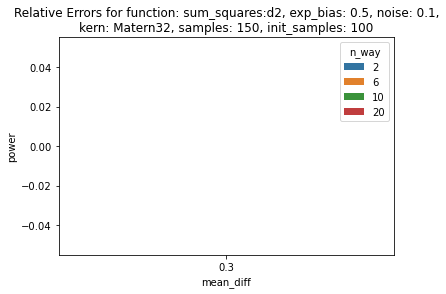

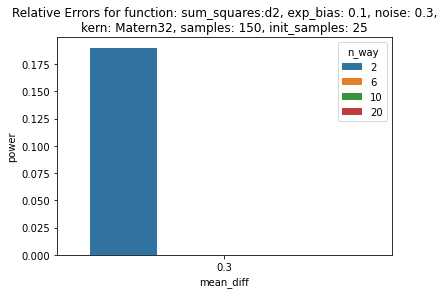

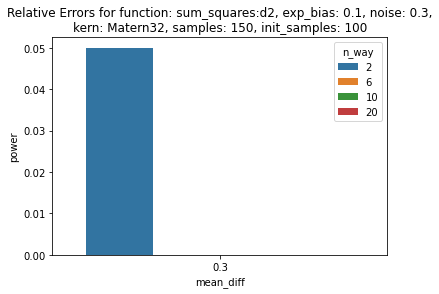

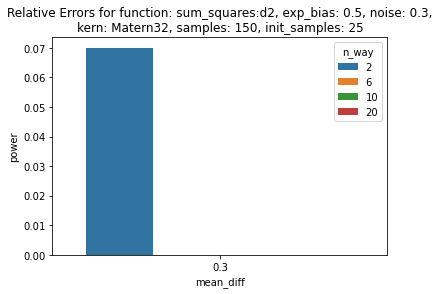

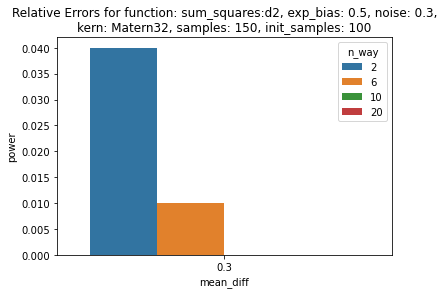

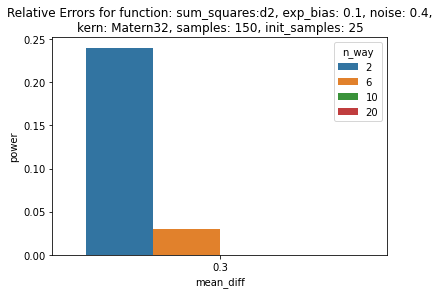

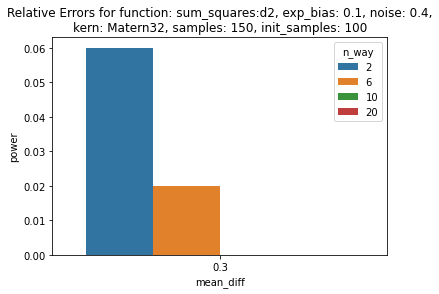

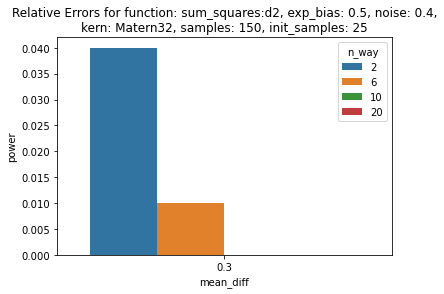

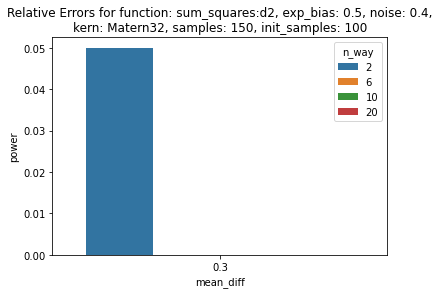

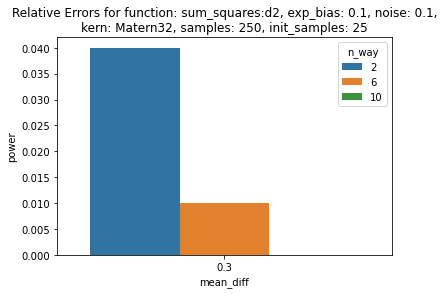

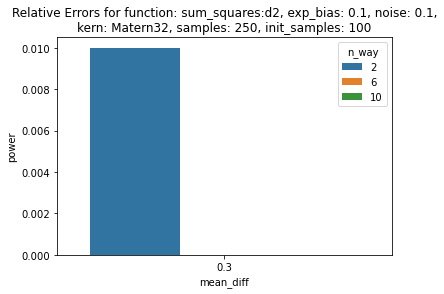

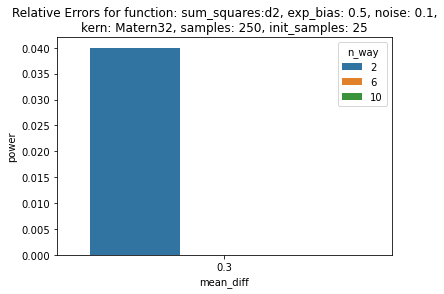

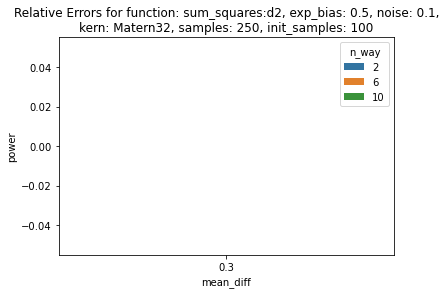

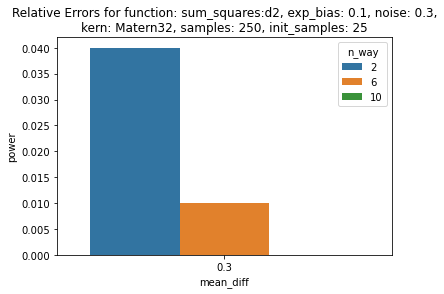

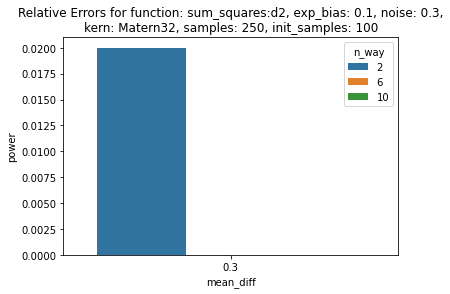

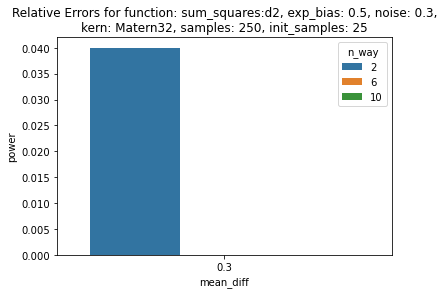

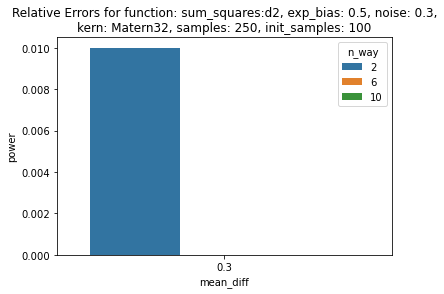

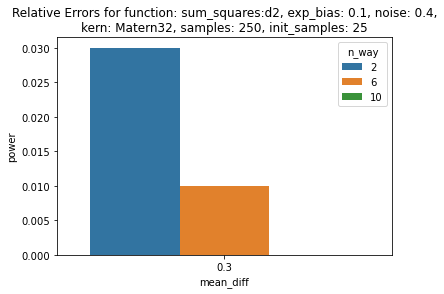

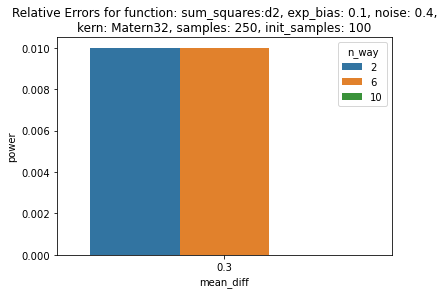

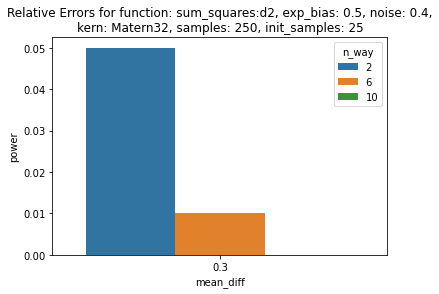

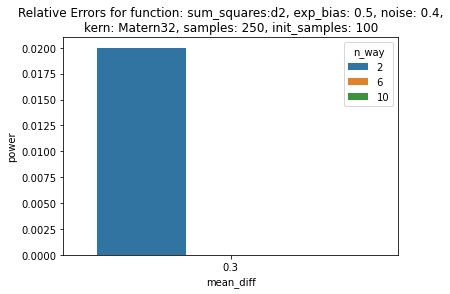

In [54]:
# TODO

# check distributions of search samples, whether method for computing degrees of freedom is reasonable
# try Hastie method for selecting degrees of freedom

# compute total number of samples with autocorrelation in classifier scores accounted for

# run power analysis with realistic number of samples

# rethink distribution of treatment arm means, just don't compare numbers of treatment means, or control ratios of variance instead of effect size of single arm 
#     can't compare number of treatment arms if all treatment variance is accounted for up front; 
#     assuming variance ratios between treatment and error are in expectation unchanged as treatments are added, more treatment arms will not affect the power of the ANOVA
# reduce search space after running the logistic regression analysis; reduce numbers of functions to one or two for now; probably use only one exp_bias value
# run power analysis with Welch's ANOVA and hypothetical sample sizes in Python
# rerun previous experiments; current experiments seem to have terminated early

# why would powers drop below alpha = 0.05? Suggests analysis is conservative?
# degrees of freedom seem low... check out concentration of samples in a few runs
# appears that increasing number of samples led to comparable to worse powers? may be interaction with number of treatment arms or other variables?


# alternative methods for selecting locations:

# select max mean even if non-significant
#     using least variable treatment in case of null result seems overly conservative; least variable treatment is plausibly treatment with weaker effects
#     in experiments with optimization, often the case that individual parameters are not significantly better than others; still use best parameters if that's all that is available
#     ML estimate would suggest using max mean no matter what
# select locations with highest t-stats vs. zero (susceptible to reversion to the mean) or vs. sham, already have multiple comparisons issue in selecting max mean or lowest variance treatments, potentially unlikely to pass sham comparison?
#     could also add multiple comparisons correction; seems likely that it wouldn't be passed
# could try all candidate locations each day or number of sessions, keeping top K after each block


# LocationSearch/PS2 analyses:
#     want estimates of distribution of effect sizes, error variances
#     test normality assumptions, may be better distributions to model data
#     LS: location effects
#     PS2/2.1: amplitude (and possibly frequency) effects
#     overall existence of effects beyond reversion to the mean with filtering events based on subjects being in a good/bad memory state
#     if time, test autocorrelations in classifier scores/Markov probs of flipping between good/bad memory states
# need to exclude events and electrodes; retrain classifier without excluded electrodes including stim contact
# LS/PS data has issue that it was collected when subjects were in a resting state (at best; John said some were asleep); 
# filtering for events when subjects are in a bad memory state may be filtering for events when subjects weren't engaged at all
# major disadvantage of stim when subjects are in a poor memory state: one might expect there to be only a few "good memory states" but many "bad" states because any of the cognitive or physiological states the brain enters into that 
# aren't related to memory might be considered bad states; Dani's analyses showing the classifier output rising and falling with word presentation could be interpreted as somewhat suspicious; not likely subjects are not trying to 
# vigorously rehearse and memorize during the non-presentation times; those analyses were not accounting for ISI



# generalize for-loops to allow for easier selection of values - use GroupBy, can iterate over groups
# add error bars with proportion tests? can add easily once "correct" sample indicators added

# comparison of maximum estimates of Gaussian processes
var = {"x": "mean_diff", "y": "power", "hue": "exp_bias"}
# Function Model power Proportion_correct pvals mus ns sems xs idx_best exp_bias n_iters n_init_samp noise_level kern mean_diff n_way

for f in run_df["Function"].unique():
    for iters in run_df["n_iters"].unique():
        for nl in run_df["noise_level"].unique():
            for eb in run_df["exp_bias"].unique():
                for init in run_df["n_init_samp"].unique():
                    for k in run_df["kern"].unique():
                        df = run_df.loc[(run_df["exp_bias"] == eb) &
                                        (run_df["noise_level"] == nl) & 
                                        (run_df["kern"] == k) &
                                        (run_df["n_iters"] == iters) &
                                        (run_df["n_init_samp"] == init) &
                                        (run_df["Function"] == f)
                                        ]
    #                     print("eb", eb, "nl", nl, "k", k, "iters", iters, "init", init)
                        if len(df) == 0: continue
    #                     if len(df["Model"].unique()) < 2: continue
    #                     print(df.head())
                        plt.figure()
                        sns.barplot(x="mean_diff", 
                                    y="power", 
                                    hue="n_way", 
                                    data=df, 
                                    ci=None)
                        title = f"Statistical Power for function: {f}, exp_bias: {eb}, noise: {nl},\nkern: {k}, samples: {iters}, init_samples: {init}"
                        plt.title(title)
plt.show()


In [187]:
# power analysis with Welch's ANOVA
# compare power vs. effect size, sample size, and number of treatments

# TODO
# check distribution of samples from Bayesian search, confirm whether method of assigning degrees of freedom roughly corresponds to number of samples near estimate point after accounting for Satterthwaite approximation of degrees of freedom

# from statsmodels.stats.oneway import anova_oneway
from pingouin import welch_anova

# effect size in standard deviations
effect = 0.3

alpha = 0.05

# samples per treatment
sample_size = 100

n_treatments = 25

sd = 1
sds = np.array([[sd] for _ in range(n_treatments)])
mus = np.array([[0.0] for _ in range(n_treatments)])
mus[0] += effect * sd

n_sims = 1000

data_df = dict()
data_df["group"] = np.repeat(np.arange(n_treatments), sample_size)

results = pd.DataFrame()
for sim in range(n_sims):
    data = np.random.normal(0, 1, (n_treatments, sample_size))
    data = data * sds + mus

    # print(data.shape)
    # print(data.mean(axis=1))

    data_df["y"] = data.reshape(-1)
    data_df = pd.DataFrame(data_df)

    # data_df.groupby("group").mean().reset_index()["y"]

    res = welch_anova(data_df, dv="y", between="group")
    # res = anova_oneway(data, use_var="unequal", welch_correction=True)

    results = results.append(res)

# print(results)

power = (results["p-unc"] < alpha).mean()
print(f"Power: {power}")

Power: 0.146


In [191]:
from pingouin import power_anova

ss_treatment = np.sum((mus - mus.mean()) ** 2)
ss_error = np.sum(sds ** 2)

eta2 = ss_treatment / (ss_treatment + ss_error)
print("eta2: ", eta2)

# pingouin.power_anova eta parameter is actually eta2
power_anova(eta=eta2, k=n_treatments, n=sample_size, power=None, alpha=alpha)

eta2:  0.0034440972000765353


0.15375593523070252

In [41]:
# sample size calculations
sess_time_sec = 25 * 60
# max_total_time_sec = 2 * 3600
# n_sessions = max_total_time_sec // sess_time_sec
n_sessions = 1
total_time_sec = sess_time_sec * n_sessions

print(f"Total experiment time: {total_time_sec/3600:0.3} hr over {n_sessions} sessions")

# stim lockout period (LocationSearch used 3 second mean value)
# ITI = 3

# closed-loop time constraints
clf_interval = 1000  #1366  # ms
clf_process_time = 200  # ms
stim_duration = 500  # ms
post_stim_lockout = 50  # ms
BO_update_time = 100  # ms
ITI = ((clf_interval + clf_process_time) * 2 + stim_duration + post_stim_lockout + BO_update_time)/1000.0

print(f"Inter-trial interval: {ITI} s")

# time in seconds to obtain closed-loop classifier output
clf_loop_sec = 0.25

min_time_per_stim = ITI

max_samples = total_time_sec//min_time_per_stim
print(f"Maximum number of stim events: {int(max_samples)}")

# expected probability of being in a (relatively) good memory state
# set by design to 0.5 assuming IID classifier predictions
p = 0.5

# under assumption of IID classifier predictions
IID_expected_time_per_stim = min_time_per_stim + clf_loop_sec * (1 + p/(1-p))

IID_expected_samples = total_time_sec/IID_expected_time_per_stim
print(f"Expected number of stim events assuming IID classifier predictions: {int(IID_expected_samples)}")

n_normalization_events = 20
n_stim_sites = 5

samples_no_norm = IID_expected_samples - n_normalization_events * n_sessions
print(f"Expected number of events excluding normalization events: {int(samples_no_norm)}")

# optimal number of sham events for Dunnett's test
# n_sham = int(samples_no_norm/(n_stim_sites + np.sqrt(n_stim_sites)) * np.sqrt(n_stim_sites))

# split evenly
n_sham = int(samples_no_norm//(n_stim_sites+1))

print(f"Sham events: {n_sham}")
samples_per_site = (samples_no_norm - n_sham) // n_stim_sites
print(f"Expected number of stim events per stim site: {int(samples_per_site)}")


Total experiment time: 0.417 hr over 1 sessions
Inter-trial interval: 3.05 s
Maximum number of stim events: 491
Expected number of stim events assuming IID classifier predictions: 422
Expected number of events excluding normalization events: 402
Sham events: 67
Expected number of stim events per stim site: 67
